Library

In [2]:
import wfdb
import numpy as np
import os
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend, iirnotch, resample, welch
from scipy.stats import entropy
import pywt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, Concatenate, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
import pandas as pd
import seaborn as sns

Preprocessing

In [3]:
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=267, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, freq=50.0, fs=267, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet='db6', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def get_record_names(path):
    record_names = []
    for file in os.listdir(path):
        if file.endswith('.dat'):
            record_name = os.path.splitext(file)[0]
            record_names.append(record_name)
    return record_names

def map_labels(labels):
    label_map = {
        '+': 1, 'N': 0, 'AFIB': 1, 'AFL': 1,
        'V': 0, 'S': 0, 'F': 0, 'J': 0, 'Q': 0, 'L': 0, 'R': 0,
        '(': 0, ')': 0, '(AFIB': 1, '(AFL': 1, '~': 0, '!': 0,
        '|': 0, '"': 0, '/': 0, 'A': 0, 'B': 0, 'E': 0,
        'j': 0, 'a': 0, 'x': 0
    }
    numeric_labels = np.array([label_map.get(label, -1) for label in labels])
    unknown_labels = set(labels) - set(label_map.keys())
    if unknown_labels:
        print(f"Peringatan: Label tidak dikenal ditemukan: {unknown_labels}")
    return numeric_labels

def compute_rr_features(signal, fs=267, use_entropy=True, visualize=False, segment_idx=0, label='unknown'):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    try:
        # Pra-pemrosesan sinyal
        signal_detrended = detrend(signal[:, 0])
        signal_denoised = wavelet_denoise(signal_detrended)
        signal_notched = notch_filter(signal_denoised, freq=50.0, fs=fs)
        signal_filtered = bandpass_filter(signal_notched, lowcut=0.5, highcut=40.0, fs=fs)
        signal_norm = (signal_filtered - np.mean(signal_filtered)) / (np.std(signal_filtered) + 1e-8)
        
        # Bersihkan sinyal dengan NeuroKit
        cleaned = nk.ecg_clean(signal_norm, sampling_rate=fs, method='neurokit')
        
        # Deteksi R-peaks
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=fs)
        r_peaks = np.array(rpeaks_info['ECG_R_Peaks'])
        
        # Delineasi gelombang P-Q-S-T
        _, info = nk.ecg_delineate(cleaned, r_peaks, sampling_rate=fs, method='peak')
        
        # Cek apakah ada R-peaks yang terdeteksi
        if len(r_peaks) < 2:
            print(f"Peringatan: Hanya {len(r_peaks)} puncak R terdeteksi pada segmen {segment_idx}.")
            return None, None, None
        
        # Hitung RR intervals dan fitur lainnya
        rr_intervals = np.diff(r_peaks) / fs * 1000  # Dalam ms
        cv_rr = np.std(rr_intervals) / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        qrs_amplitude = np.max(signal_norm) - np.min(signal_norm)
        bpm = 60000 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
        
        # Hitung entropy
        if use_entropy:
            hist, _ = np.histogram(signal_norm, bins=50, density=True)
            signal_entropy = entropy(hist)
            signal_entropy = (signal_entropy - np.mean(hist)) / (np.std(hist) + 1e-8)
        else:
            freqs, psd = welch(signal_norm, fs=fs, nperseg=256)
            signal_entropy = np.sum(psd)
        
        # Visualisasi jika diaktifkan
        if visualize:
            visualize_r_peaks(cleaned, r_peaks, label, fs, segment_idx)
        
        return rr_intervals, [cv_rr, qrs_amplitude, signal_entropy, bpm], r_peaks
    except Exception as e:
        print(f"Error deteksi puncak R: {e}")
        return None, None, None

def visualize_r_peaks(signal, r_peaks, label, fs=267, segment_idx=0):
    if r_peaks is None or len(r_peaks) == 0:
        print("Tidak ada R-peaks untuk divisualisasikan.")
        return
    plt.figure(figsize=(10, 4))
    t = np.arange(len(signal)) / fs
    plt.plot(t, signal, label='ECG Signal')
    plt.plot(t[r_peaks], signal[r_peaks], 'rx', label='R-Peaks')
    plt.title(f'R-Peak Detection - Segment {segment_idx} ({label})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig(f'r_peaks_segment_{segment_idx}_{label}.png', dpi=300)
    plt.show()

def augment_signal(signal, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, signal.shape)
    scaled_signal = signal * np.random.uniform(0.8, 1.2)
    shifted_signal = scaled_signal + np.random.uniform(-0.2, 0.2)
    return shifted_signal + noise

def normalize_signal(signal):
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    signal_norm = (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)
    return signal_norm

Load Dataset

In [4]:
#Path and Record Names
path_afdb = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\mit-bih-atrial-fibrillation-database-1.0.0 (1)\files'
path_arrhythmia = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\mit-bih-arrhythmia-database-1.0.0'
path_nsrdb = r'D:\Tugas Akhir\Pemodelan\CNN_LSTM\mit-bih-normal-sinus-rhythm-database-1.0.0'

record_names_afdb = get_record_names(path_afdb)
record_names_arrhythmia = ['201', '202', '210', '221', '222']
record_names_nsrdb = get_record_names(path_nsrdb)

print("Path AFDB:", path_afdb)
print("Path Arrhythmia:", path_arrhythmia)
print("Path NSRDB:", path_nsrdb)
print("Record Names AFDB:", record_names_afdb)
print("Record Names Arrhythmia:", record_names_arrhythmia)
print("Record Names NSRDB:", record_names_nsrdb)

Path AFDB: D:\Tugas Akhir\Pemodelan\CNN_LSTM\mit-bih-atrial-fibrillation-database-1.0.0 (1)\files
Path Arrhythmia: D:\Tugas Akhir\Pemodelan\CNN_LSTM\mit-bih-arrhythmia-database-1.0.0
Path NSRDB: D:\Tugas Akhir\Pemodelan\CNN_LSTM\mit-bih-normal-sinus-rhythm-database-1.0.0
Record Names AFDB: ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995', '07162', '07859', '07879', '07910', '08215', '08219', '08378', '08405', '08434', '08455']
Record Names Arrhythmia: ['201', '202', '210', '221', '222']
Record Names NSRDB: ['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453', '18177', '18184', '19088', '19090', '19093', '19140', '19830']


AF Data

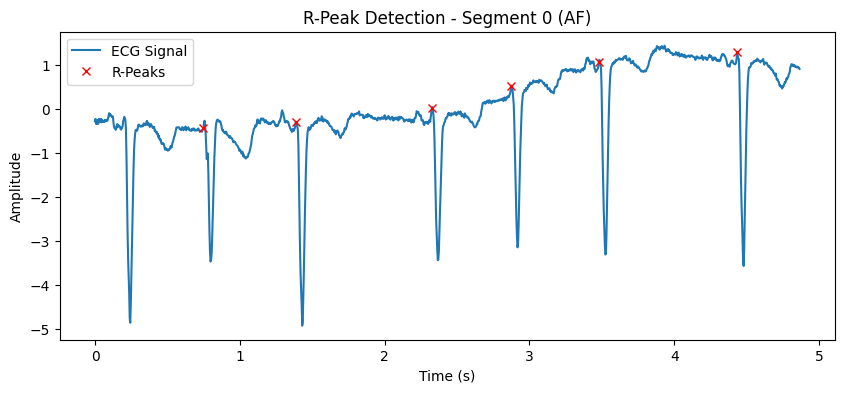

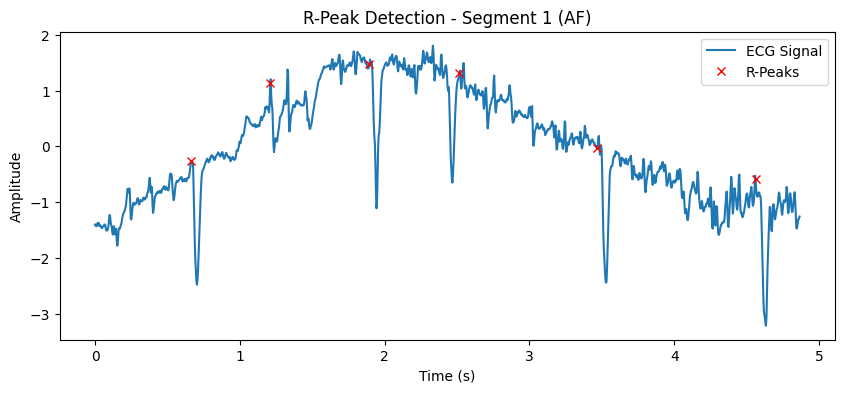

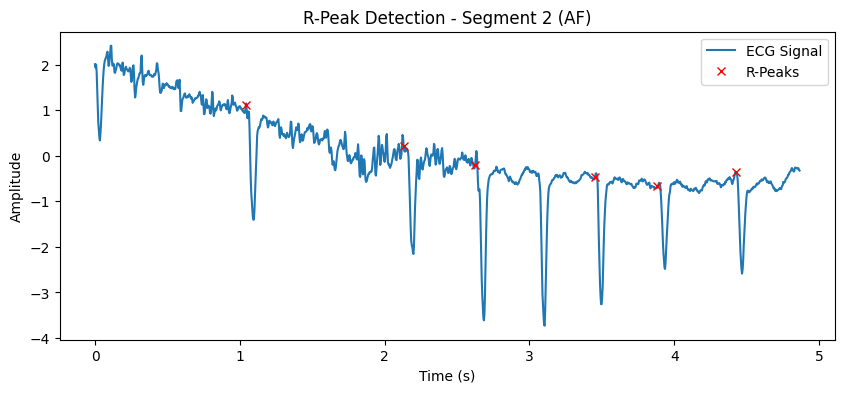

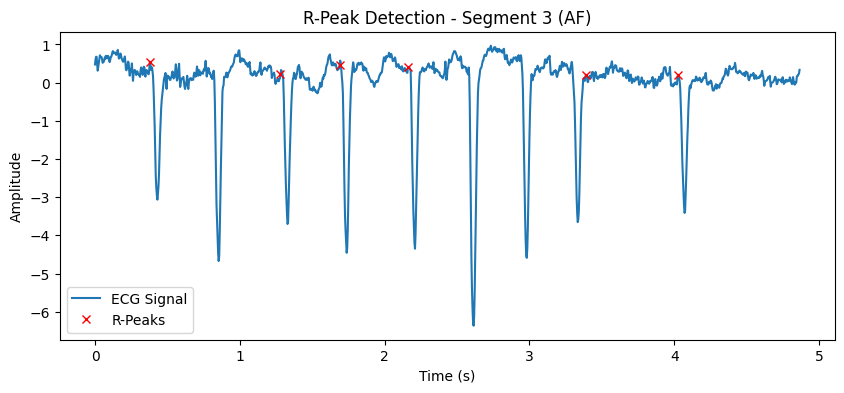

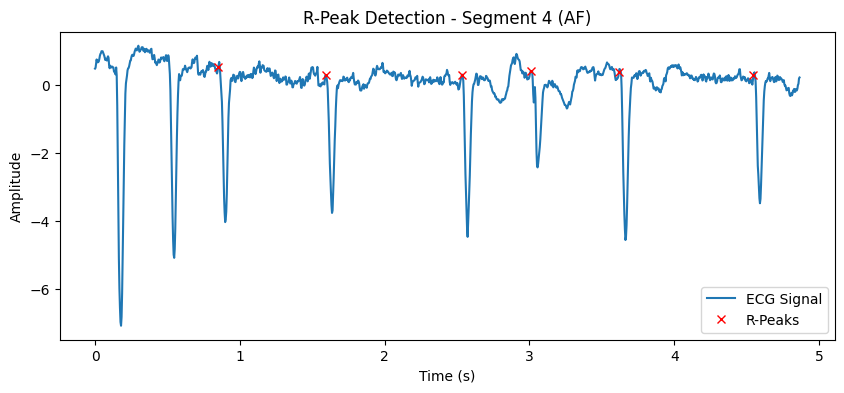

c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer
Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer


c:\Users\Tamausa\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error deteksi puncak R: cannot convert float NaN to integer
AF segments loaded: 1129/1170
Total segmen AF yang dimuat: 1129
Mean Entropy AF: 9.9234, Std Entropy AF: 2.5644
Mean BPM AF: 87.8493, Std BPM AF: 20.3165
AF Data Loaded: 1129 1129 1129
Mean Entropy AF: 9.9234, Std Entropy AF: 2.5644
Mean BPM AF: 87.8493, Std BPM AF: 20.3165


In [5]:
# Load AF Data
def load_af_data(path_afdb, path_arrhythmia, record_names_afdb, record_names_arrhythmia, segment_length=1300, fs=267, target_segments=1170, lead_index=1):
    all_data = []
    all_labels = []
    all_rr_features = []
    all_r_peaks = []
    count_af = 0
    
    for record_name in record_names_afdb:
        if count_af >= target_segments:
            break
        try:
            record = wfdb.rdrecord(f'{path_afdb}/{record_name}', channels=[lead_index])
            signal = resample(record.p_signal, int(len(record.p_signal) * fs / record.fs))
            annotation = wfdb.rdann(f'{path_afdb}/{record_name}', 'atr')
            labels = annotation.symbol
            sample_indices = annotation.sample
            sample_indices = (sample_indices * fs / record.fs).astype(int)
            numeric_labels = map_labels(labels)
            
            step = int(segment_length * 0.5)
            for i in range(0, len(signal) - segment_length, step):
                if count_af >= target_segments:
                    break
                signal_segment = signal[i:i + segment_length]
                if len(signal_segment) != segment_length:
                    continue
                segment_start = i
                segment_end = i + segment_length
                segment_labels = numeric_labels[(sample_indices >= segment_start) & (sample_indices < segment_end)]
                if len(segment_labels) == 0 or -1 in segment_labels:
                    continue
                if not all(label == 1 for label in segment_labels):
                    continue
                rr_intervals, features, r_peaks = compute_rr_features(signal_segment, fs)
                if rr_intervals is None or features is None:
                    continue
                signal_segment_norm = normalize_signal(signal_segment)
                all_data.append(augment_signal(signal_segment_norm))
                all_labels.append(1)
                all_rr_features.append(features)
                all_r_peaks.append(r_peaks)
                if count_af < 5:  # Visualisasi 5 segmen pertama
                    visualize_r_peaks(signal_segment_norm.flatten(), r_peaks, 'AF', fs, count_af)
                count_af += 1
                print(f"AF segments loaded: {count_af}/{target_segments}", end='\r')
        except Exception as e:
            print(f"Error memuat AFDB {record_name}: {e}")
            continue
    
    if count_af < target_segments:
        for record_name in record_names_arrhythmia:
            if count_af >= target_segments:
                break
            try:
                record = wfdb.rdrecord(f'{path_arrhythmia}/{record_name}', channels=[lead_index])
                signal = resample(record.p_signal, int(len(record.p_signal) * fs / record.fs))
                annotation = wfdb.rdann(f'{path_arrhythmia}/{record_name}', 'atr')
                labels = annotation.symbol
                sample_indices = annotation.sample
                sample_indices = (sample_indices * fs / record.fs).astype(int)
                numeric_labels = map_labels(labels)
                
                step = int(segment_length * 0.5)
                for i in range(0, len(signal) - segment_length, step):
                    if count_af >= target_segments:
                        break
                    signal_segment = signal[i:i + segment_length]
                    if len(signal_segment) != segment_length:
                        continue
                    segment_start = i
                    segment_end = i + segment_length
                    segment_labels = numeric_labels[(sample_indices >= segment_start) & (sample_indices < segment_end)]
                    if len(segment_labels) == 0 or -1 in segment_labels:
                        continue
                    if not all(label == 1 for label in segment_labels):
                        continue
                    rr_intervals, features, r_peaks = compute_rr_features(signal_segment, fs)
                    if rr_intervals is None or features is None:
                        continue
                    signal_segment_norm = normalize_signal(signal_segment)
                    all_data.append(augment_signal(signal_segment_norm))
                    all_labels.append(1)
                    all_rr_features.append(features)
                    all_r_peaks.append(r_peaks)
                    count_af += 1
                    print(f"AF segments loaded: {count_af}/{target_segments}", end='\r')
            except Exception as e:
                print(f"Error memuat Arrhythmia {record_name}: {e}")
                continue
    
    all_data = np.array(all_data)
    all_labels = np.array(all_labels)
    all_rr_features = np.array(all_rr_features)
    print(f"\nTotal segmen AF yang dimuat: {len(all_data)}")
    print(f"Mean Entropy AF: {np.mean(all_rr_features[:, 2]):.4f}, Std Entropy AF: {np.std(all_rr_features[:, 2]):.4f}")
    print(f"Mean BPM AF: {np.mean(all_rr_features[:, 3]):.4f}, Std BPM AF: {np.std(all_rr_features[:, 3]):.4f}")
    return all_data, all_labels, all_rr_features, all_r_peaks

X_af, y_af, rr_af, r_peaks_af = load_af_data(path_afdb, path_arrhythmia, record_names_afdb, record_names_arrhythmia, target_segments=1170, fs=267, lead_index=1)
print("AF Data Loaded:", len(X_af), len(y_af), len(rr_af))
print(f"Mean Entropy AF: {np.mean(rr_af[:, 2]):.4f}, Std Entropy AF: {np.std(rr_af[:, 2]):.4f}")
print(f"Mean BPM AF: {np.mean(rr_af[:, 3]):.4f}, Std BPM AF: {np.std(rr_af[:, 3]):.4f}")

Normal Data

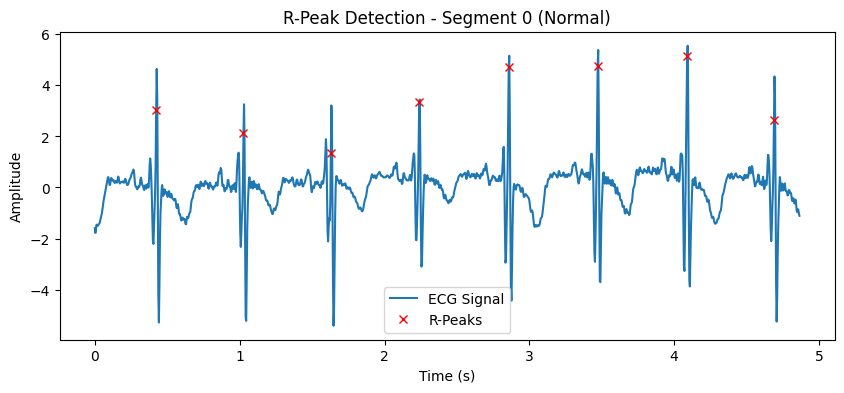

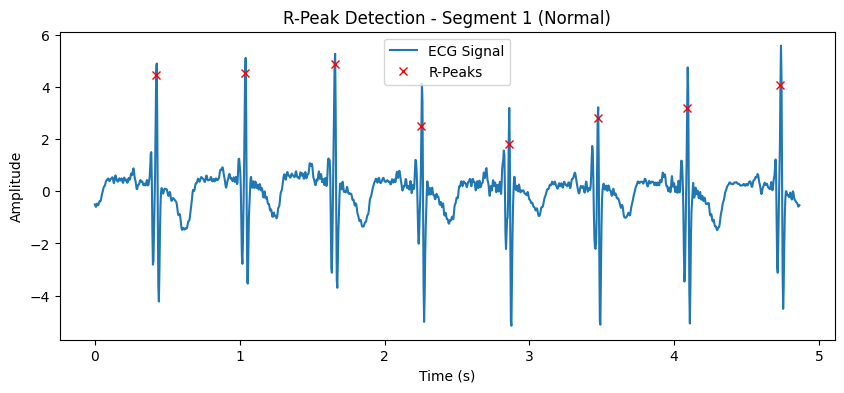

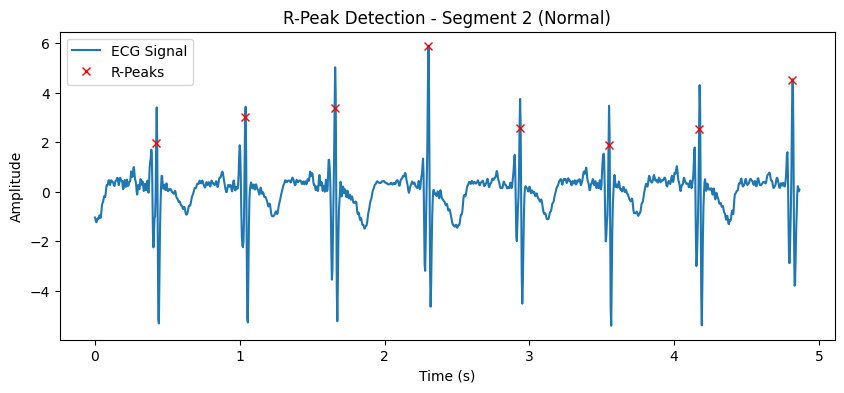

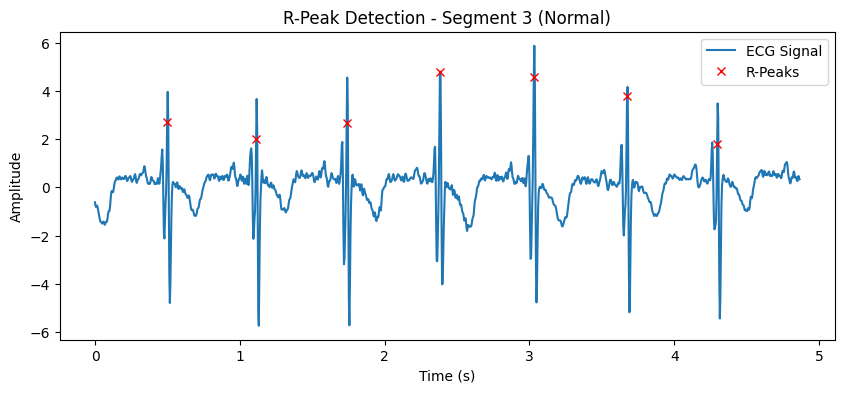

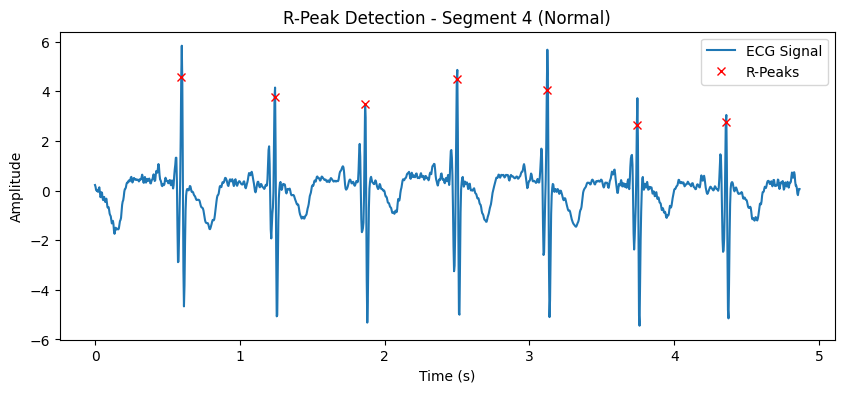

Normal segments loaded: 1170/1170
Total segmen normal yang dimuat: 1170
Statistik CV R-R Normal: mean=0.0299, std=1.9e-02
Statistik QRS Amplitude Normal: mean=9.7394, std=8.7e-01
Statistik Signal Entropy Normal: mean=11.8942, std=1.6e+00
Statistik BPM Normal: mean=89.3872, std=9.9e+00
Normal Data Loaded: 1170 1170 1170
Mean Entropy Normal: 11.8942, Std Entropy Normal: 1.6424
Mean BPM Normal: 89.3872, Std BPM Normal: 9.9476


In [6]:
# Load Normal Data
def load_normal_data(path_normal, record_names, limit=1150, segment_length=1300, fs=267, lead_index=1):
    all_data = []
    all_labels = []
    all_rr_features = []
    all_r_peaks = []
    count_normal = 0
    
    for record_name in record_names:
        if count_normal >= limit:
            break
        try:
            record = wfdb.rdrecord(f'{path_normal}/{record_name}', channels=[lead_index])
            signal = resample(record.p_signal, int(len(record.p_signal) * fs / record.fs))
            step = int(segment_length * 0.5)
            for i in range(0, len(signal) - segment_length, step):
                if count_normal >= limit:
                    break
                segment = signal[i:i + segment_length]
                if len(segment) != segment_length:
                    continue
                rr_intervals, features, r_peaks = compute_rr_features(segment, fs)
                if rr_intervals is None or features is None:
                    continue
                if features[0] > 0.1:  # Batas CV R-R
                    continue
                segment_norm = normalize_signal(segment)
                all_data.append(augment_signal(segment_norm))
                all_labels.append(0)
                all_rr_features.append(features)
                all_r_peaks.append(r_peaks)
                if count_normal < 5:  # Visualisasi 5 segmen pertama
                    visualize_r_peaks(segment_norm.flatten(), r_peaks, 'Normal', fs, count_normal)
                count_normal += 1
                print(f"Normal segments loaded: {count_normal}/{limit}", end='\r')
        except Exception as e:
            print(f"Error memuat NSRDB {record_name}: {e}")
            continue
    
    all_data = np.array(all_data)
    all_labels = np.array(all_labels)
    all_rr_features = np.array(all_rr_features)
    print(f"\nTotal segmen normal yang dimuat: {len(all_data)}")
    print(f"Statistik CV R-R Normal: mean={np.mean(all_rr_features[:, 0]):.4f}, std={np.std(all_rr_features[:, 0]):.1e}")
    print(f"Statistik QRS Amplitude Normal: mean={np.mean(all_rr_features[:, 1]):.4f}, std={np.std(all_rr_features[:, 1]):.1e}")
    print(f"Statistik Signal Entropy Normal: mean={np.mean(all_rr_features[:, 2]):.4f}, std={np.std(all_rr_features[:, 2]):.1e}")
    print(f"Statistik BPM Normal: mean={np.mean(all_rr_features[:, 3]):.4f}, std={np.std(all_rr_features[:, 3]):.1e}")
    return all_data, all_labels, all_rr_features, all_r_peaks

X_normal, y_normal, rr_normal, r_peaks_normal = load_normal_data(path_nsrdb, record_names_nsrdb, limit=1170, fs=267, lead_index=1)
print("Normal Data Loaded:", len(X_normal), len(y_normal), len(rr_normal))
print(f"Mean Entropy Normal: {np.mean(rr_normal[:, 2]):.4f}, Std Entropy Normal: {np.std(rr_normal[:, 2]):.4f}")
print(f"Mean BPM Normal: {np.mean(rr_normal[:, 3]):.4f}, Std BPM Normal: {np.std(rr_normal[:, 3]):.4f}")


Ektrasi Fitur


Jumlah label AF: Counter({1: 1129})
Jumlah label Normal: Counter({0: 1170})
X_af shape: (1129, 1300, 1)
X_normal shape: (1170, 1300, 1)
Shape of rr_features_norm: (2299, 4)
Shape of X: (2299, 1300, 1)
Shape of rr_features_norm: (2299, 4)
Semua data disimpan ke 'processed_data.pkl'


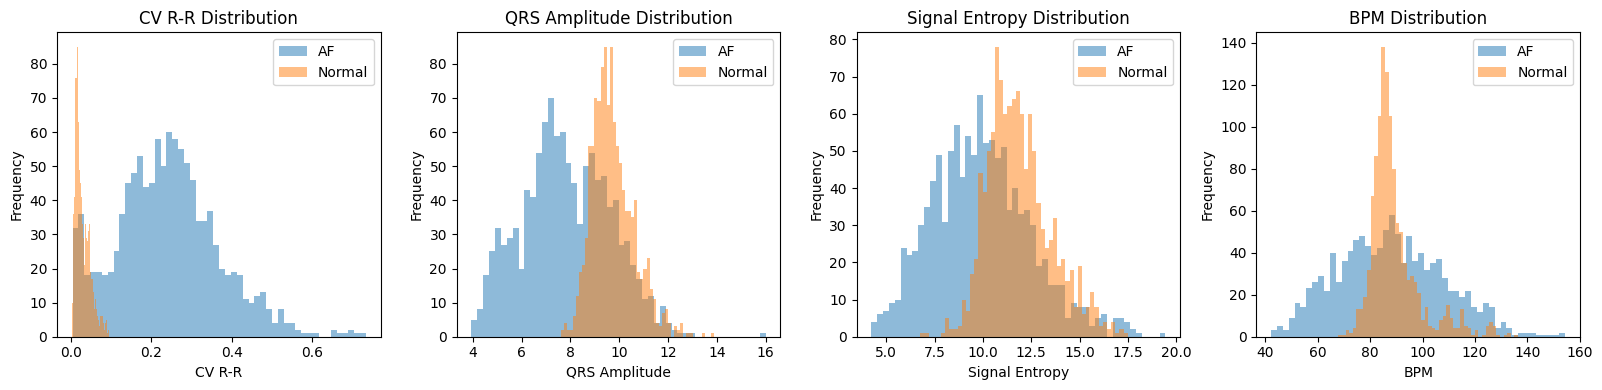


Data dimuat dari 'processed_data.pkl':
X shape: (2299, 1300, 1)
y shape: (2299,)
rr_features shape: (2299, 4)
rr_features_norm shape: (2299, 4)
scaler: <class 'sklearn.preprocessing._data.StandardScaler'>


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
import os
from collections import Counter

# Asumsikan X_af, X_normal, y_af, y_normal, rr_af, rr_normal sudah didefinisikan

# Data Integration
print("\nJumlah label AF:", Counter(y_af.tolist()))
print("Jumlah label Normal:", Counter(y_normal.tolist()))

print("X_af shape:", X_af.shape)
print("X_normal shape:", X_normal.shape)

# Memilih lead II jika diperlukan
if X_af.shape[2] != 1:
    print("Memilih lead II untuk X_af")
    X_af = X_af[:, :, :1]
if X_normal.shape[2] != 1:
    print("Memilih lead II untuk X_normal")
    X_normal = X_normal[:, :, :1]

# Menggabungkan data
X = np.concatenate((X_af, X_normal), axis=0)
y = np.concatenate((y_af, y_normal), axis=0)
rr_features = np.concatenate((rr_af, rr_normal), axis=0)

# Terapkan StandardScaler pada rr_features
scaler = StandardScaler()
rr_features_norm = scaler.fit_transform(rr_features)
print("Shape of rr_features_norm:", rr_features_norm.shape)

# Memastikan bentuk X
if X.shape[1] != 1300 or X.shape[2] != 1:
    print("Mengatur ulang bentuk X menjadi (num_samples, 1300, 1)")
    X = X.reshape(X.shape[0], 1300, 1)

print("Shape of X:", X.shape)
print("Shape of rr_features_norm:", rr_features_norm.shape)

# Simpan semua data ke satu file .pkl
data_dict = {
    'X': X,
    'y': y,
    'rr_features': rr_features,
    'rr_features_norm': rr_features_norm,
    'scaler': scaler
}
joblib.dump(data_dict, 'processed_data.pkl')
print("Semua data disimpan ke 'processed_data.pkl'")

# Visualisasi Fitur
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.hist(rr_af[:, 0], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 0], alpha=0.5, label='Normal', bins=50)
plt.xlabel('CV R-R')
plt.ylabel('Frequency')
plt.legend()
plt.title('CV R-R Distribution')

plt.subplot(1, 4, 2)
plt.hist(rr_af[:, 1], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 1], alpha=0.5, label='Normal', bins=50)
plt.xlabel('QRS Amplitude')
plt.ylabel('Frequency')
plt.legend()
plt.title('QRS Amplitude Distribution')

plt.subplot(1, 4, 3)
plt.hist(rr_af[:, 2], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 2], alpha=0.5, label='Normal', bins=50)
plt.xlabel('Signal Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.title('Signal Entropy Distribution')

plt.subplot(1, 4, 4)
plt.hist(rr_af[:, 3], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 3], alpha=0.5, label='Normal', bins=50)
plt.xlabel('BPM')
plt.ylabel('Frequency')
plt.legend()
plt.title('BPM Distribution')

plt.tight_layout()
plt.savefig('rr_features_distribution.png', dpi=300)
plt.show()

# Memeriksa dan memuat data
if os.path.exists('processed_data.pkl'):
    try:
        data = joblib.load('processed_data.pkl')
        print("\nData dimuat dari 'processed_data.pkl':")
        print(f"X shape: {data['X'].shape}")
        print(f"y shape: {data['y'].shape}")
        print(f"rr_features shape: {data['rr_features'].shape}")
        print(f"rr_features_norm shape: {data['rr_features_norm'].shape}")
        print(f"scaler: {type(data['scaler'])}")
    except Exception as e:
        print(f"Error memuat 'processed_data.pkl': {e}")
else:
    print("File 'processed_data.pkl' tidak ditemukan!")


Jumlah label AF: Counter({1: 1129})
Jumlah label Normal: Counter({0: 1170})
X_af shape: (1129, 1300, 1)
X_normal shape: (1170, 1300, 1)
Shape of rr_features_norm: (2299, 4)
Shape of X: (2299, 1300, 1)
Shape of rr_features_norm: (2299, 4)
Semua data disimpan ke file terpisah


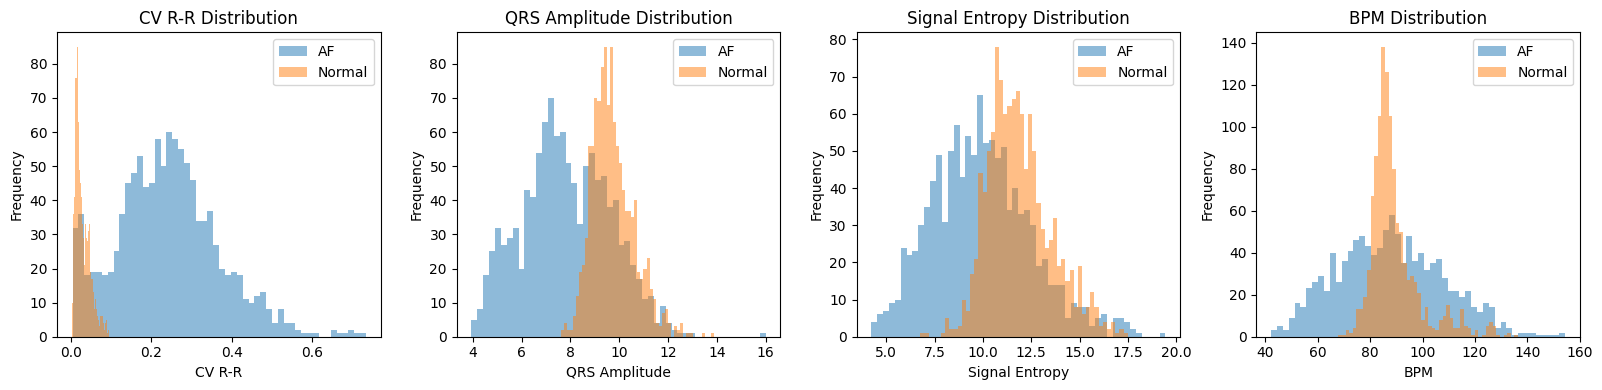


Data dimuat dari 'X_data.pkl':
Data shape: (2299, 1300, 1)

Data dimuat dari 'y_data.pkl':
Data shape: (2299,)

Data dimuat dari 'rr_features_data.pkl':
Data shape: (2299, 4)

Data dimuat dari 'rr_features_norm_data.pkl':
Data shape: (2299, 4)

Data dimuat dari 'scaler_data.pkl':
Data shape: N/A


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
import os
from collections import Counter

# Asumsikan X_af, X_normal, y_af, y_normal, rr_af, rr_normal sudah didefinisikan

# Data Integration
print("\nJumlah label AF:", Counter(y_af.tolist()))
print("Jumlah label Normal:", Counter(y_normal.tolist()))

print("X_af shape:", X_af.shape)
print("X_normal shape:", X_normal.shape)

# Memilih lead II jika diperlukan
if X_af.shape[2] != 1:
    print("Memilih lead II untuk X_af")
    X_af = X_af[:, :, :1]
if X_normal.shape[2] != 1:
    print("Memilih lead II untuk X_normal")
    X_normal = X_normal[:, :, :1]

# Menggabungkan data
X = np.concatenate((X_af, X_normal), axis=0)
y = np.concatenate((y_af, y_normal), axis=0)
rr_features = np.concatenate((rr_af, rr_normal), axis=0)

# Terapkan StandardScaler pada rr_features
scaler = StandardScaler()
rr_features_norm = scaler.fit_transform(rr_features)
print("Shape of rr_features_norm:", rr_features_norm.shape)

# Memastikan bentuk X
if X.shape[1] != 1300 or X.shape[2] != 1:
    print("Mengatur ulang bentuk X menjadi (num_samples, 1300, 1)")
    X = X.reshape(X.shape[0], 1300, 1)

print("Shape of X:", X.shape)
print("Shape of rr_features_norm:", rr_features_norm.shape)

# Simpan data ke file terpisah
joblib.dump(X, 'X_data.pkl')
joblib.dump(y, 'y_data.pkl')
joblib.dump(rr_features, 'rr_features_data.pkl')
joblib.dump(rr_features_norm, 'rr_features_norm_data.pkl')
joblib.dump(scaler, 'scaler_data.pkl')

print("Semua data disimpan ke file terpisah")

# Visualisasi Fitur
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.hist(rr_af[:, 0], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 0], alpha=0.5, label='Normal', bins=50)
plt.xlabel('CV R-R')
plt.ylabel('Frequency')
plt.legend()
plt.title('CV R-R Distribution')

plt.subplot(1, 4, 2)
plt.hist(rr_af[:, 1], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 1], alpha=0.5, label='Normal', bins=50)
plt.xlabel('QRS Amplitude')
plt.ylabel('Frequency')
plt.legend()
plt.title('QRS Amplitude Distribution')

plt.subplot(1, 4, 3)
plt.hist(rr_af[:, 2], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 2], alpha=0.5, label='Normal', bins=50)
plt.xlabel('Signal Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.title('Signal Entropy Distribution')

plt.subplot(1, 4, 4)
plt.hist(rr_af[:, 3], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 3], alpha=0.5, label='Normal', bins=50)
plt.xlabel('BPM')
plt.ylabel('Frequency')
plt.legend()
plt.title('BPM Distribution')

plt.tight_layout()
plt.savefig('rr_features_distribution.png', dpi=300)
plt.show()

# Memeriksa dan memuat data
files = ['X_data.pkl', 'y_data.pkl', 'rr_features_data.pkl', 'rr_features_norm_data.pkl', 'scaler_data.pkl']
for file in files:
    if os.path.exists(file):
        try:
            data = joblib.load(file)
            print(f"\nData dimuat dari '{file}':")
            print(f"Data shape: {data.shape if isinstance(data, np.ndarray) else 'N/A'}")
        except Exception as e:
            print(f"Error memuat '{file}': {e}")
    else:
        print(f"File '{file}' tidak ditemukan!")



Jumlah label AF: Counter({1: 1129})
Jumlah label Normal: Counter({0: 1170})
X_af shape: (1129, 1300, 1)
X_normal shape: (1170, 1300, 1)
Shape of rr_features_norm: (2299, 4)
Shape of X: (2299, 1300, 1)
Shape of rr_features_norm: (2299, 4)
Semua data disimpan ke file .npy


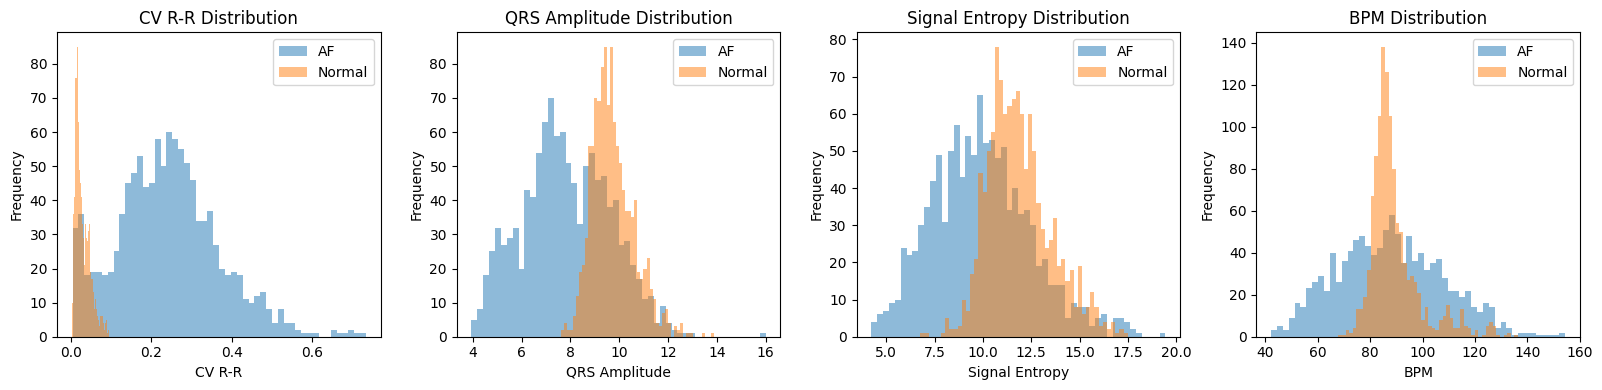


Data 'X' shape: (2299, 1300, 1)
Data 'y' shape: (2299,)
Data 'rr_features' shape: (2299, 4)
Data 'rr_features_norm' shape: (2299, 4)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
from collections import Counter

# Asumsikan X_af, X_normal, y_af, y_normal, rr_af, rr_normal sudah didefinisikan

# Data Integration
print("\nJumlah label AF:", Counter(y_af.tolist()))
print("Jumlah label Normal:", Counter(y_normal.tolist()))

print("X_af shape:", X_af.shape)
print("X_normal shape:", X_normal.shape)

# Memilih lead II jika diperlukan
if X_af.shape[2] != 1:
    print("Memilih lead II untuk X_af")
    X_af = X_af[:, :, :1]
if X_normal.shape[2] != 1:
    print("Memilih lead II untuk X_normal")
    X_normal = X_normal[:, :, :1]

# Menggabungkan data
X = np.concatenate((X_af, X_normal), axis=0)
y = np.concatenate((y_af, y_normal), axis=0)
rr_features = np.concatenate((rr_af, rr_normal), axis=0)

# Terapkan StandardScaler pada rr_features
scaler = StandardScaler()
rr_features_norm = scaler.fit_transform(rr_features)
print("Shape of rr_features_norm:", rr_features_norm.shape)

# Memastikan bentuk X
if X.shape[1] != 1300 or X.shape[2] != 1:
    print("Mengatur ulang bentuk X menjadi (num_samples, 1300, 1)")
    X = X.reshape(X.shape[0], 1300, 1)

print("Shape of X:", X.shape)
print("Shape of rr_features_norm:", rr_features_norm.shape)

# Simpan data ke file .npy
np.save('X_data.npy', X)
np.save('y_data.npy', y)
np.save('rr_features_data.npy', rr_features)
np.save('rr_features_norm_data.npy', rr_features_norm)
np.save('scaler_data.npy', scaler)  # Jika Anda ingin menyimpan scaler, Anda perlu serialisasi terlebih dahulu jika perlu

print("Semua data disimpan ke file .npy")

# Visualisasi Fitur
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.hist(rr_af[:, 0], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 0], alpha=0.5, label='Normal', bins=50)
plt.xlabel('CV R-R')
plt.ylabel('Frequency')
plt.legend()
plt.title('CV R-R Distribution')

plt.subplot(1, 4, 2)
plt.hist(rr_af[:, 1], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 1], alpha=0.5, label='Normal', bins=50)
plt.xlabel('QRS Amplitude')
plt.ylabel('Frequency')
plt.legend()
plt.title('QRS Amplitude Distribution')

plt.subplot(1, 4, 3)
plt.hist(rr_af[:, 2], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 2], alpha=0.5, label='Normal', bins=50)
plt.xlabel('Signal Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.title('Signal Entropy Distribution')

plt.subplot(1, 4, 4)
plt.hist(rr_af[:, 3], alpha=0.5, label='AF', bins=50)
plt.hist(rr_normal[:, 3], alpha=0.5, label='Normal', bins=50)
plt.xlabel('BPM')
plt.ylabel('Frequency')
plt.legend()
plt.title('BPM Distribution')

plt.tight_layout()
plt.savefig('rr_features_distribution.png', dpi=300)
plt.show()

# Menampilkan bentuk data untuk memastikan
print(f"\nData 'X' shape: {X.shape}")
print(f"Data 'y' shape: {y.shape}")
print(f"Data 'rr_features' shape: {rr_features.shape}")
print(f"Data 'rr_features_norm' shape: {rr_features_norm.shape}")


Build Model

In [7]:
# Build Model (Diperbarui: 5 Layer)
def build_model(hp):
    ecg_input = Input(shape=(1300, 1), name='ecg_input')
    rr_input = Input(shape=(4,), name='rr_input')
    x = ecg_input
    
    # Layer 1: Conv1D
    x = Conv1D(
        filters=32,
        kernel_size=hp.Choice('kernel_size_0', [3, 5, 7], default=5),
        strides=1,
        activation='relu',
        padding='same',
        kernel_regularizer=l2(hp.Float('l2_reg_0', 1e-4, 1e-2, sampling='log', default=1e-3))
    )(x)
    
    # Layer 2: MaxPooling1D
    x = MaxPooling1D(pool_size=2)(x)
    
    # Layer 3: LSTM
    x = LSTM(
        units=hp.Int('lstm_units', 32, 128, step=32, default=64),
        return_sequences=False
    )(x)
    
    # Layer 4: Dropout
    x = Dropout(hp.Float('dropout', 0.1, 0.3, step=0.1, default=0.2))(x)
    
    # Concatenate dengan rr_input
    x = Concatenate()([x, rr_input])
    
    # Layer 5: Dense (output)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[ecg_input, rr_input], outputs=output)
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'nadam'], default='adam'),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

5 K-Fold Cross Validation

In [ ]:
# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\nTraining Fold {fold + 1}")
    
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    rr_train_fold, rr_val_fold = rr_features_norm[train_idx], rr_features_norm[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    tuner = kt.Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=20,
        factor=3,
        directory=f'tuner_lstm_dir_fold_{fold + 1}',  # Diperbarui
        project_name='af_detection'
    )
    
    checkpoint = ModelCheckpoint(f'best_model_lstm_layer_fold_{fold + 1}.h5', monitor='val_accuracy', save_best_only=True)  # Diperbarui
    
    tuner.search(
        [X_train_fold, rr_train_fold], y_train_fold,
        epochs=20,
        validation_data=([X_val_fold, rr_val_fold], y_val_fold),
        callbacks=[early_stopping, lr_scheduler, checkpoint],
        verbose=1
    )
    
    best_model = tuner.get_best_models(num_models=1)[0]
    
    history = best_model.fit(
        [X_train_fold, rr_train_fold], y_train_fold,
        epochs=20,
        validation_data=([X_val_fold, rr_val_fold], y_val_fold),
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )
    
    val_accuracy = max(history.history['val_accuracy'])
    fold_scores.append(val_accuracy)
    print(f"Fold {fold + 1} Validation Accuracy: {val_accuracy:.4f}")
    
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'fold_{fold + 1}_accuracy.png', dpi=300)
    plt.close()

print(f"\nK-Fold CV Results: Mean Accuracy = {np.mean(fold_scores):.4f}, Std = {np.std(fold_scores):.4f}")

Trial 30 Complete [00h 07m 56s]
val_accuracy: 0.9978213310241699

Best val_accuracy So Far: 1.0
Total elapsed time: 02h 11m 28s
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 43s 581ms/step - accuracy: 0.9852 - loss: 0.0670 - val_accuracy: 0.9978 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 615ms/step - accuracy: 0.9891 - loss: 0.0495 - val_accuracy: 0.9521 - val_loss: 0.1375 - learning_rate: 0.0010
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 542ms/step - accuracy: 0.9657 - loss: 0.1208 - val_accuracy: 0.9978 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 536ms/step - accuracy: 0.9773 - loss: 0.0795 - val_accuracy: 0.9913 - val_loss: 0.0600 - learning_rate: 0.0010
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 581ms/step - accuracy: 0.9903 - loss: 0.0499 - val_accuracy: 1.0000 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 585ms/step - accuracy: 0.9966 - loss: 0.0249 - val_accuracy: 0.99

In [10]:
print(f"K-Fold CV Results: Mean Accuracy = {np.mean(fold_scores):.4f}, Std = {np.std(fold_scores):.4f}")

K-Fold CV Results: Mean Accuracy = 0.9948, Std = 0.0049



Evaluating Fold 1...
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step
Fold 1 - Confusion Matrix:
[[232   2]
 [  4 222]]
Fold 1 - ROC AUC: 0.999
Fold 1 - Precision-Recall AUC: 0.999

Evaluating Fold 2...


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 479ms/step
Fold 2 - Confusion Matrix:
[[229   5]
 [ 19 207]]
Fold 2 - ROC AUC: 0.978
Fold 2 - Precision-Recall AUC: 0.984

Evaluating Fold 3...


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step
Fold 3 - Confusion Matrix:
[[232   2]
 [  8 218]]
Fold 3 - ROC AUC: 0.963
Fold 3 - Precision-Recall AUC: 0.972

Evaluating Fold 4...


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step
Fold 4 - Confusion Matrix:
[[234   0]
 [  6 220]]
Fold 4 - ROC AUC: 0.999
Fold 4 - Precision-Recall AUC: 0.999

Evaluating Fold 5...


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step
Fold 5 - Confusion Matrix:
[[232   2]
 [  3 223]]
Fold 5 - ROC AUC: 1.000
Fold 5 - Precision-Recall AUC: 1.000


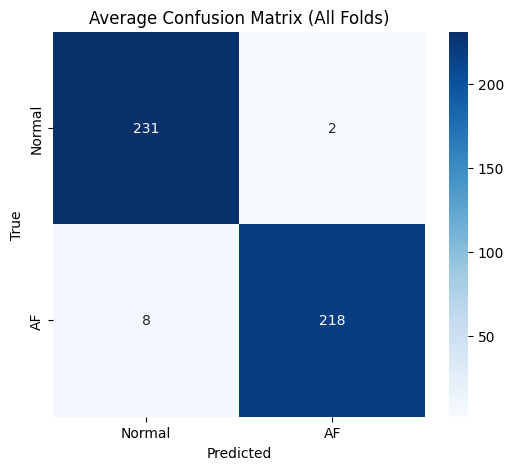

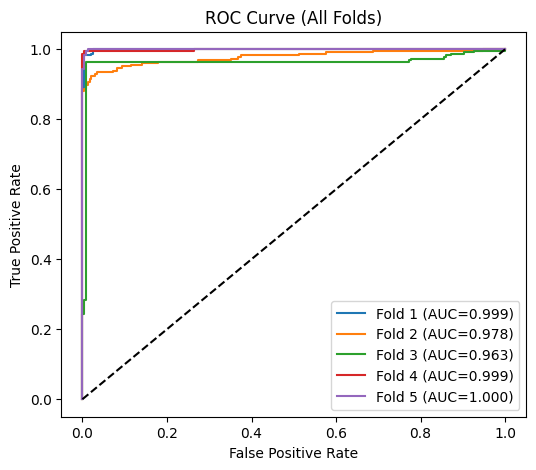

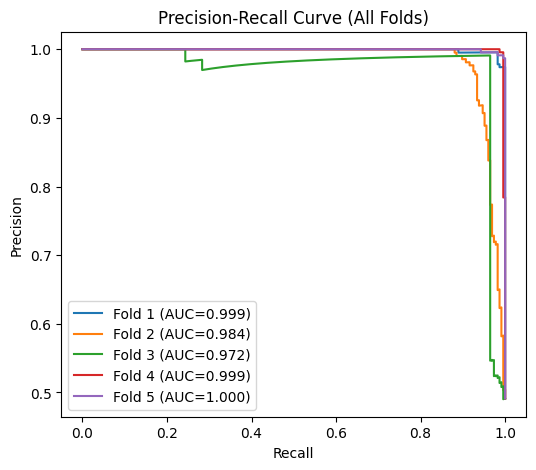


Average Metrics Across All Folds:
Average ROC AUC: 0.988
Average Precision-Recall AUC: 0.991
Average Precision: 0.978
Average Recall: 0.978
Average F1-Score: 0.978
Average Confusion Matrix:
[[231   2]
 [  8 218]]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from datetime import datetime

# --- Data split ---
X_train, X_test, y_train, y_test, rr_train, rr_test = train_test_split(
    X, y, rr_features_norm, test_size=0.2, random_state=42, stratify=y
)

# --- Fungsi evaluasi per fold ---
def evaluate_fold(model_path, X_test, y_test, rr_test):
    # Load model
    model = load_model(model_path)

    # Kalau model fit pakai dua input, pakai predict([X_test, rr_test])
    y_pred_prob = model.predict([X_test, rr_test]).flatten()

    # Confusion matrix
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_binary)
    
    # Classification report
    report = classification_report(y_test, y_pred_binary, output_dict=True)
    
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)
    
    return conf_matrix, report, roc_auc, pr_auc, y_pred_prob, (fpr, tpr), (recall, precision)

# --- Evaluasi all folds ---
all_conf_matrices = []
all_reports = []
all_roc_aucs = []
all_pr_aucs = []
all_y_pred_probs = []
all_rocs = []
all_prs = []

for fold in range(1, 6):
    model_path = f'best_model_lstm_layer_fold_{fold}.h5'
    print(f"\nEvaluating Fold {fold}...")
    conf_matrix, report, roc_auc, pr_auc, y_pred_prob, roc_points, pr_points = evaluate_fold(
        model_path, X_test, y_test, rr_test
    )

    all_conf_matrices.append(conf_matrix)
    all_reports.append(report)
    all_roc_aucs.append(roc_auc)
    all_pr_aucs.append(pr_auc)
    all_y_pred_probs.append(y_pred_prob)
    all_rocs.append(roc_points)
    all_prs.append(pr_points)

    print(f"Fold {fold} - Confusion Matrix:\n{conf_matrix}")
    print(f"Fold {fold} - ROC AUC: {roc_auc:.3f}")
    print(f"Fold {fold} - Precision-Recall AUC: {pr_auc:.3f}")

# --- Rata-rata ---
avg_conf_matrix = np.mean(all_conf_matrices, axis=0).astype(int)
avg_roc_auc = np.mean(all_roc_aucs)
avg_pr_auc = np.mean(all_pr_aucs)
avg_precision = np.mean([r['weighted avg']['precision'] for r in all_reports])
avg_recall = np.mean([r['weighted avg']['recall'] for r in all_reports])
avg_f1 = np.mean([r['weighted avg']['f1-score'] for r in all_reports])

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# --- Visualisasi Confusion Matrix Average ---
plt.figure(figsize=(6,5))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'AF'], yticklabels=['Normal', 'AF'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (All Folds)')
plt.savefig(f'confusion_matrix_avg_{timestamp}.png', dpi=300)
plt.show()

# --- Visualisasi ROC Curve semua fold ---
plt.figure(figsize=(6,5))
for i, ((fpr, tpr), roc_auc) in enumerate(zip(all_rocs, all_roc_aucs)):
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (All Folds)')
plt.legend(loc='lower right')
plt.savefig(f'roc_curve_all_{timestamp}.png', dpi=300)
plt.show()

# --- Visualisasi PR Curve semua fold ---
plt.figure(figsize=(6,5))
for i, ((recall, precision), pr_auc) in enumerate(zip(all_prs, all_pr_aucs)):
    plt.plot(recall, precision, label=f'Fold {i+1} (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (All Folds)')
plt.legend(loc='lower left')
plt.savefig(f'pr_curve_all_{timestamp}.png', dpi=300)
plt.show()

# --- Summary print ---
print("\nAverage Metrics Across All Folds:")
print(f"Average ROC AUC: {avg_roc_auc:.3f}")
print(f"Average Precision-Recall AUC: {avg_pr_auc:.3f}")
print(f"Average Precision: {avg_precision:.3f}")
print(f"Average Recall: {avg_recall:.3f}")
print(f"Average F1-Score: {avg_f1:.3f}")
print(f"Average Confusion Matrix:\n{avg_conf_matrix}")
